# SI 330 - Homework 3: AWS, RDS, MySQL, and Visualization
## Top-level goal:
To explore the goodreads database that we created during the past few classes.

**NOTE**: You will need to review your notebooks from the past few classes to complete this assignment.

Take a look at the first few entries in the ```books``` table.  Specifically, take a look at the ```authors``` field.  

You'll notice that some entries contain multiple authors such as:
>  'Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-Doubleday'

(that's from iloc[14])

Note too that some non-ASCII characters in the author names are misformed.  That's my fault and can be ignored for the purposes of this assignment.

Your task is to "break out" those authors into a separate dataframe, then use either merge, join, or any other functionality from pandas to answer the following questions.  Please note that there are multiple ways to figure out the answers.  You can, of course, choose to do things in a "pythonic" way rather than a "pandorable" way, but it will be more difficult to get full points if you do so.

You will also need to use some of the visualization techniques we learned when we covered matplotlib a few weeks ago.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pymysql
%matplotlib inline

In [3]:
connection = pymysql.connect(host='si330-gprime-instance.cst7dbvgzgvt.us-east-1.rds.amazonaws.com', # remove this before submitting
                             user='...', # remove this before submitting
                             password='...', # remove this before submitting
                             db='goodreads',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

### Q1: How many unique authors are there?

In [3]:
q1 = pd.read_sql('SELECT authors FROM books', con=connection)
q1.head()

,authors
0,Suzanne Collins
1,"J.K. Rowling, Mary GrandPrÃ©"
2,Stephenie Meyer
3,Harper Lee
4,F. Scott Fitzgerald


In [4]:
def numunique(l):
    d = dict()
    for x in l: 
        d[x] = d.get(x, 0) + 1
    return len(d)
            

In [5]:
names = list()
final = list()
for index, x in q1.itertuples():
    names.append(x)
for y in names:
    if ',' in y:
        z = y.split(',')
        final = z + final
    else:
        final.append(y)
numunique(final)


5944

There are 5,944 unique authors in this dataset. 

### Q2: Create a barchart that has the number of authors from 1 to n across the horizontal axis and the number of books having that number of authors as the vertical axis.

In [39]:
def numauth(l):
    return len(l.split(','))

Text(0.5, 0, 'Number of Authors on a Book')

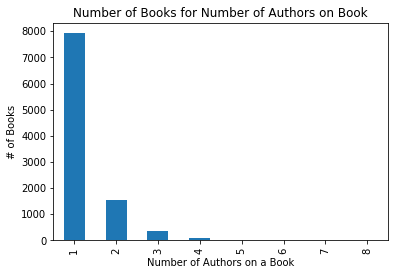

In [40]:
q2 = pd.read_sql('SELECT authors, original_title FROM books', con=connection)
q2['NumAuthors'] = q2['authors'].apply(numauth)
q2plot = q2.groupby('NumAuthors').size().plot(kind = "bar", y = 'Number of Books', title = "Number of Books for Number of Authors on Book")
q2plot.set_ylabel('# of Books')
q2plot.set_xlabel('Number of Authors on a Book')





### Q3: How many books as J.K. Rowling co-authored with someone else?

In [41]:
q3 = pd.read_sql('''SELECT authors
                  FROM books
                  WHERE authors LIKE "%J.K. Rowling%"''', con=connection)
q3['NumAuthors'] = q3['authors'].apply(numauth)
q3 = q3[q3['NumAuthors'] > 1]
len(q3)

19

J.K. Rowling has co-authored 19 books with someone else. 

### Q4: Who has co-authored books with J.K Rowling?

In [42]:
q4 = q3.copy()
q4lst = q4.authors.tolist()
a = list()
for x in q4lst:
    if ',' in x:
        y = x.split(', ')
        a = y + a
    else:
        a.append(x)
print('The authors that have co-authored books with J.K. Rowling are:')
list(set([z for z in a if z != 'J.K. Rowling']))



The authors that have co-authored books with J.K. Rowling are:


['Albus Dumbledore',
 'Robert Galbraith',
 'Newt Scamander',
 'John Tiffany',
 'Rufus Beck',
 'MinaLima',
 'Kennilworthy Whisp',
 'Joel Holland',
 'Jack Thorne',
 'Melissa Anelli',
 'Mary GrandPrÃ©']

### Q5: Which book has the largest number of authors?  How many authors?  Who are the authors?

In [43]:
q5 = q2.copy()
bignum = q5.sort_values(by='NumAuthors', ascending = False)
big = bignum[bignum['NumAuthors'] == bignum['NumAuthors'].max()]
print('There were multiple books with the largest number of authors. They are listed below.\n')
use = big.values.tolist()
for x in use:
    names = x[0].split(',')
    print('Title: {}'.format(x[1]))
    print('# Authors: {}'.format(x[2]))
    print('Author Names: {}\n'.format(names))

There were multiple books with the largest number of authors. They are listed below.

Title: The Sandman: The Kindly Ones
# Authors: 8
Author Names: ['Neil Gaiman', ' Marc Hempel', ' Richard Case', " D'Israeli", ' Teddy Kristiansen', ' Glyn Dillon', ' Charles Vess', ' Dea']

Title: The Sandman: A Game of You
# Authors: 8
Author Names: ['Neil Gaiman', ' Shawn McManus', ' Colleen Doran', ' Bryan Talbot', ' George Pratt', ' Stan Woch', ' Dick Giordano', ' Tod']

Title: The Sandman: Fables and Reflections
# Authors: 8
Author Names: ['Neil Gaiman', ' Bryan Talbot', ' Stan Woch', ' P. Craig Russell', ' Shawn McManus', ' John Watkiss', ' Jill Thompson', ' ']

Title: America (The Book): A Citizen's Guide to Democracy Inaction
# Authors: 8
Author Names: ['Jon Stewart', ' Ben Karlin', ' David Javerbaum', ' Rich Bloomquist', ' Steve Bodow', ' Tim Carvell', ' Eric Drysdale', ' ']

Title: Earth: A Visitor's Guide to the Human Race 
# Authors: 8
Author Names: ['Jon Stewart', ' Rory Albanese', ' Kevi

### Q6: Which author's books have been tagged with the largest number of unique tags?

In [36]:
q6 = pd.read_sql('''SELECT title, authors, COUNT(DISTINCT books_tags.tag_id) as "UniTags"
                    FROM books, books_tags
                    WHERE books.goodreads_book_id = books_tags.goodreads_book_id
                    GROUP BY title
                    ORDER BY UniTags DESC;
                    ''', con=connection)
sep = q6['authors'].str.split(', ', expand = True)
temp = pd.merge(q6, sep, left_on = q6.index, right_on = sep.index)
d = dict()
for x in temp.values.tolist():
    auths = x[4:]
    for y in auths:
        if type(y) == str:
            d[y] = d.get(y, 0) + x[3]
sorted(d.items(), key = lambda x: x[1], reverse = True)[:5]

[('James Patterson', 9827),
 ('Stephen King', 9532),
 ('Nora Roberts', 6439),
 ('Dean Koontz', 6400),
 ('Terry Pratchett', 5000)]

The author that has been tagged with the largest number of unique tags is James Patterson. 

He has 9827 unique tags. 